# Part 1: BBC News Classification

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

The first step involves loading the BBC News classification dataset from Kaggle, which contains training data, test data, and sample solutions. We examine the basic structure of our training data to understand what we're working with.

In [2]:
train_data = pd.read_csv("/kaggle/input/bbc-news-classification/BBC News Train.csv")
test_data = pd.read_csv("/kaggle/input/bbc-news-classification/BBC News Test.csv")
sample_solutions = pd.read_csv("/kaggle/input/bbc-news-classification/BBC News Sample Solution.csv")

# Get general information on data
print(train_data.info())
print(train_data.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


This reveals that our dataset contains 1,490 news articles with three columns: ArticleId, Text, and Category. Each article belongs to one of five categories: business, entertainment, politics, sport, and tech.

Understanding the distribution of categories in our training data is crucial for identifying potential class imbalance issues that might affect our model's performance.

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


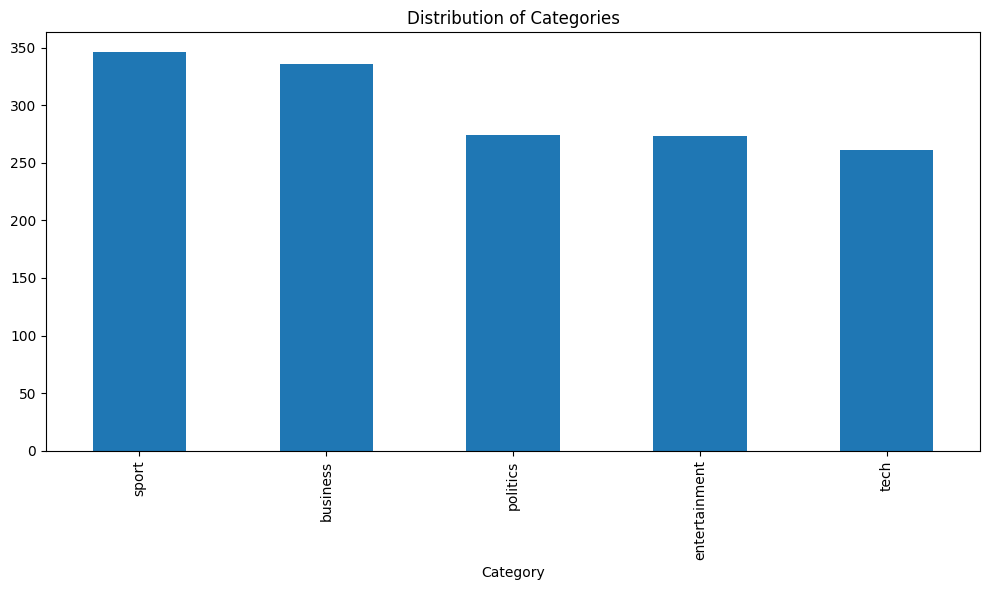

In [3]:
print(train_data['Category'].value_counts())
plt.figure(figsize=(10, 6))
train_data['Category'].value_counts().plot(kind='bar')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.tight_layout()
plt.show()

The analysis shows that the dataset is relatively balanced, with sport having the most articles (346) and tech having the fewest (261). This balanced distribution is favorable for our matrix factorization approach.

Analyzing the distribution of text lengths helps us understand the variation in article sizes and can inform our feature extraction strategy.

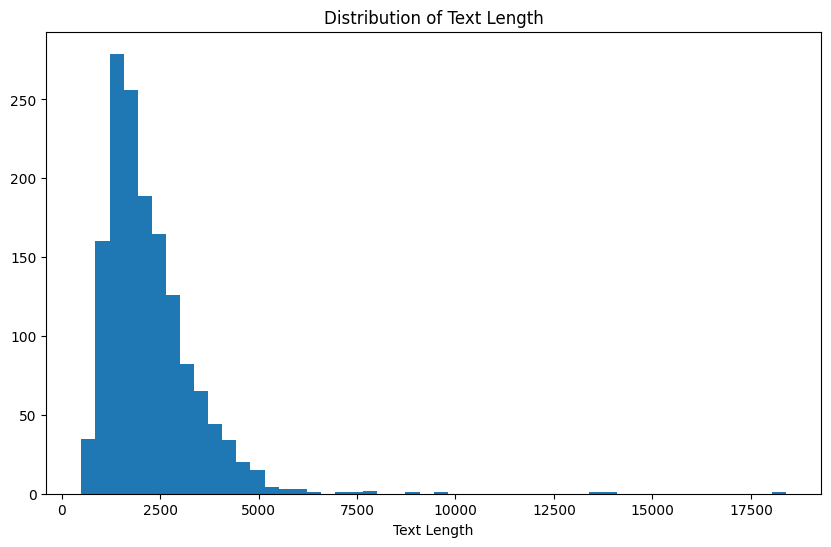

In [4]:
train_data['text_length'] = train_data['Text'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(train_data['text_length'], bins=50)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.show()

This visualization reveals the range of article lengths in our dataset, which will help us understand the complexity of the text processing task ahead. Before proceeding with modeling, we need to identify and handle duplicate articles that could lead to data leakage between training and test sets.

In [5]:
train_duplicates = train_data.duplicated(subset=['Text'], keep=False)
n_train_duplicates = train_duplicates.sum()
print(f"Number of duplicate texts in training data: {n_train_duplicates}")


test_duplicates = test_data.duplicated(subset=['Text'], keep=False)
n_test_duplicates = test_duplicates.sum()
print(f"\nNumber of duplicate texts in test data: {n_test_duplicates}")

train_texts = set(train_data['Text'].values)
test_texts = set(test_data['Text'].values)
overlap = train_texts.intersection(test_texts)
print(f"Number of texts appearing in both train and test: {len(overlap)}")

Number of duplicate texts in training data: 100

Number of duplicate texts in test data: 26
Number of texts appearing in both train and test: 36


This analysis identifies 100 duplicate texts in training data, 26 in test data, and 36 texts that appear in both sets - all potential sources of data leakage that must be addressed. To ensure fair evaluation and prevent data leakage, we systematically remove duplicate articles and overlapping texts between training and test sets.

In [6]:
initial_train_size = len(train_data)
initial_test_size = len(test_data)
    
# Remove exact duplicates from training data
train_data = train_data.drop_duplicates(subset=['Text'], keep='first').reset_index(drop=True)
train_duplicates_removed = initial_train_size - len(train_data)
    
# Remove exact duplicates from test data
test_data = test_data.drop_duplicates(subset=['Text'], keep='first').reset_index(drop=True)
test_duplicates_removed = initial_test_size - len(test_data)
    
print(f"Removed {train_duplicates_removed} duplicate texts from training data")
print(f"Training data size: {initial_train_size} -> {len(train_data)}")
print(f"Removed {test_duplicates_removed} duplicate texts from test data")
print(f"Test data size: {initial_test_size} -> {len(test_data)}")


# Remove exact duplicates that overlap between training and test data
train_texts_set = set(train_data['Text'].values)
test_texts_set = set(test_data['Text'].values)
overlap_texts = train_texts_set.intersection(test_texts_set)
        

print(f"{len(overlap_texts)} overlapping texts between train and test sets")
            
train_data = train_data[~train_data['Text'].isin(overlap_texts)].reset_index(drop=True)
overlap_removed = len(overlap_texts)
print(f"Final training data size: {len(train_data)}")

Removed 50 duplicate texts from training data
Training data size: 1490 -> 1440
Removed 13 duplicate texts from test data
Test data size: 735 -> 722
36 overlapping texts between train and test sets
Final training data size: 1404


After cleaning, our training data reduced from 1,490 to 1,404 articles, ensuring no data leakage between training and test sets. Raw text data requires preprocessing to convert it into a format suitable for machine learning. Our preprocessing pipeline standardizes the text format for consistent feature extraction.

In [7]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    text = ' '.join(text.split())
    
    return text

This function converts text to lowercase, removes punctuation and numbers, and normalizes whitespace to create clean, consistent text for analysis. We convert preprocessed text into numerical features using Term Frequency-Inverse Document Frequency (TF-IDF) vectorization, which captures the importance of words relative to the entire dataset.

In [8]:
train_data['processed_text'] = train_data['Text'].apply(preprocess_text)
test_data['processed_text'] = test_data['Text'].apply(preprocess_text)

In [9]:
tfidf = TfidfVectorizer(
    stop_words='english',
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2) 
)

In [10]:
all_texts = list(train_data['processed_text']) + list(test_data['processed_text'])
    
tfidf_matrix = tfidf.fit_transform(all_texts)

n_train = len(train_data)
X_train_tfidf = tfidf_matrix[:n_train]
X_test_tfidf = tfidf_matrix[n_train:]

feature_names = tfidf.get_feature_names_out()
tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()

print(f"TF-IDF matrix: {tfidf_matrix.shape}")
print(f"Training features: {X_train_tfidf.shape}")
print(f"Test features: {X_test_tfidf.shape}")

TF-IDF matrix: (2126, 61503)
Training features: (1404, 61503)
Test features: (722, 61503)


The TF-IDF vectorizer creates a 61,503 dimensions using both unigrams and bigrams, filtering out common English stop words and rare terms. We fit the vectorizer on both training and test data to ensure consistent features for the unsupervised matrix factorization approach. Analyzing the most important words in our TF-IDF matrix will help us understand what linguistic patterns our model will learn from.

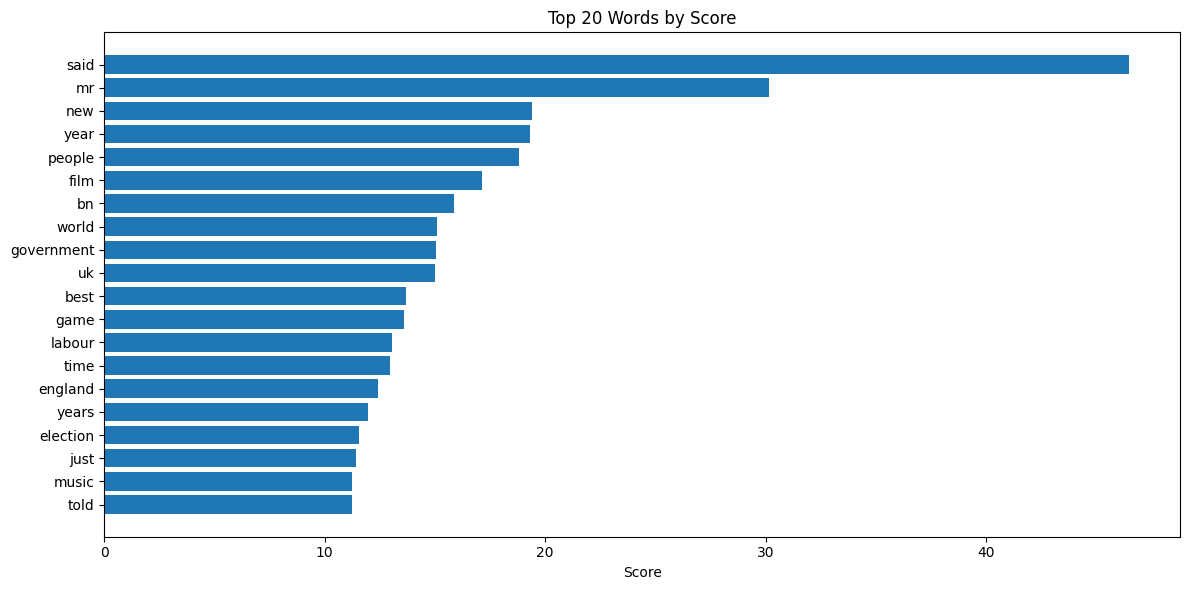

In [11]:
top_indices = tfidf_scores.argsort()[-20:][::-1]
top_words = [feature_names[i] for i in top_indices]
top_scores = [tfidf_scores[i] for i in top_indices]
    
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_words)), top_scores)
plt.yticks(range(len(top_words)), top_words)
plt.xlabel('Score')
plt.title('Top 20 Words by Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

This visualization reveals the most frequently occurring and important terms across all articles, providing insight into the vocabulary that distinguishes different news categories. Word clouds for each category help visualize the distinctive vocabulary that characterizes different types of news articles.

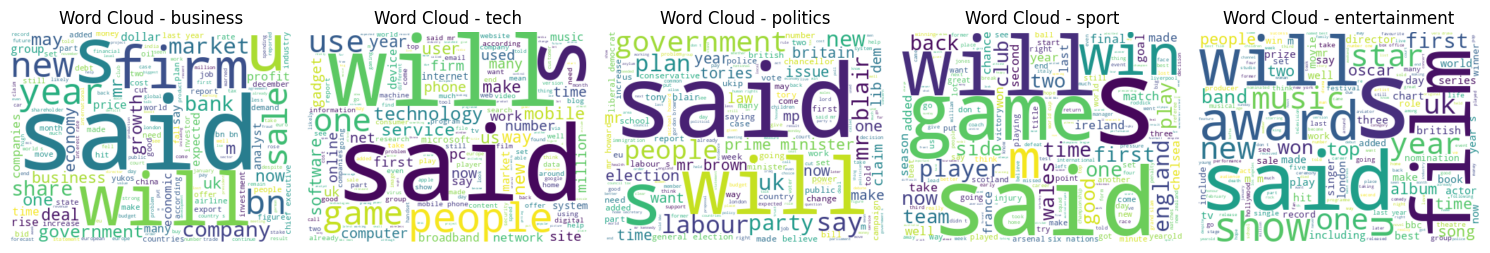

In [12]:
categories = train_data['Category'].unique()
fig, axes = plt.subplots(1, 5, figsize=(15, 10))
axes = axes.flatten()
    
for i, category in enumerate(categories[:5]):
    if i < len(axes):
        category_text = ' '.join(train_data[train_data['Category'] == category]['processed_text'])
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate(category_text)
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Word Cloud - {category}')
        axes[i].axis('off')
    
plt.tight_layout()
plt.show()

These word clouds reveal category-specific vocabulary patterns that will help us understand how well our matrix factorization approach can distinguish between different news types. We will now begin with a baseline Non-negative Matrix Factorization (NMF) model to establish initial performance and understand the dimensionality reduction process.

In [13]:
model = NMF(n_components=10)
model.fit(tfidf_matrix)
            
X_train_mf = model.transform(X_train_tfidf)
X_test_mf = model.transform(X_test_tfidf)
        
print(f"Reduced feature dimensions: {X_train_mf.shape[1]}")

classifier = MultinomialNB()
            
classifier.fit(X_train_mf, train_data['Category'])
            
train_pred = classifier.predict(X_train_mf)
train_accuracy = accuracy_score(train_data['Category'], train_pred)
            
print(f"Training accuracy: {train_accuracy:.4f}")


Reduced feature dimensions: 10
Training accuracy: 0.6254


This initial model reduces our 61,503 TF-IDF features to 10 latent topics and achieves 62.5% accuracy, establishing a baseline for further optimization. Now we can systematically test different numbers of components to find the optimal dimensionality for our matrix factorization.

In [14]:
component_range = [5, 10, 15, 20, 30, 50]
tuning_results = []

for n_components in component_range:
    if 'processed_text' in train_data.columns and 'Category' in train_data.columns:
        
        nmf_model = NMF(n_components=n_components)
        
        nmf_model.fit(tfidf_matrix)
        X_train_nmf = nmf_model.transform(X_train_tfidf)
        X_test_nmf = nmf_model.transform(X_test_tfidf)
        
        classifier = MultinomialNB()
        classifier.fit(X_train_nmf, train_data['Category'])
        
        train_pred = classifier.predict(X_train_nmf)
        train_accuracy = accuracy_score(train_data['Category'], train_pred)
        
        tuning_results.append({
            'Components': n_components,
            'Train_Accuracy': train_accuracy
        })


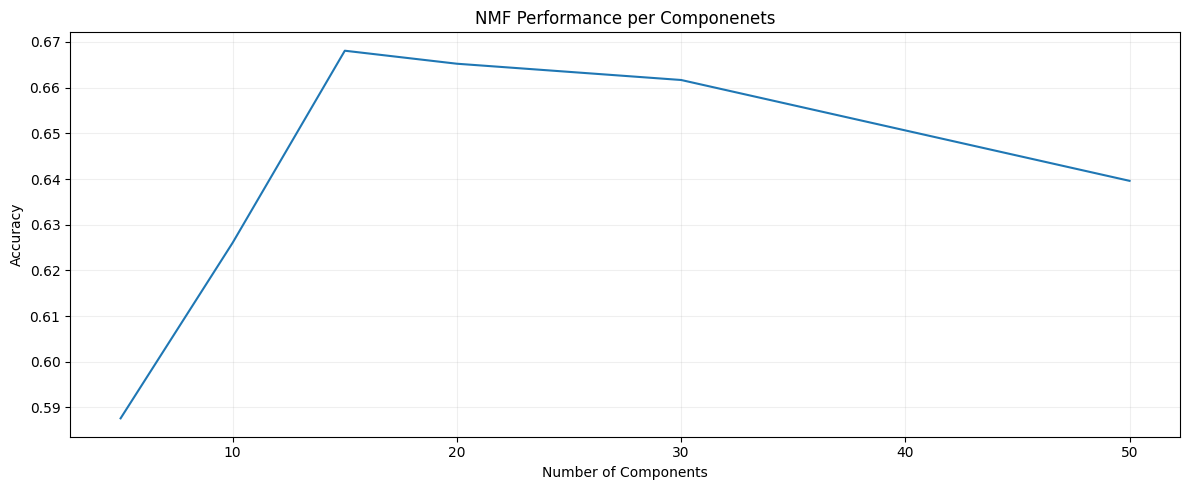

In [15]:
tuning_df = pd.DataFrame(tuning_results)
    
plt.figure(figsize=(12, 5))
plt.plot(tuning_df['Components'], tuning_df['Train_Accuracy'])
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('NMF Performance per Componenets')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

This analysis helps us identify the optimal number of latent topics that best captures the underlying structure in our news articles while avoiding overfitting. To optimize our NMF model, we will conduct an additional systematic search across multiple hyperparameters including initialization methods, solvers, and regularization parameters.

In [16]:
nmf_param_grid = {
    'n_components': [15],
    'init': ['random', 'nndsvd', 'nndsvda', 'nndsvdar'],
    'solver': ['mu', 'cd'],
    'alpha_W': [0.0, 0.01, 0.1, 0.5],
    'alpha_H': [0.0, 0.01, 0.1, 0.5],
    'max_iter': [100, 200, 500, 1000],
    'tol': [1e-4, 1e-3, 1e-2],
    'beta_loss': ['frobenius', 'kullback-leibler']
}

efficient_param_combinations = [
    # Initialization method
    {'n_components': [15], 'init': ['random', 'nndsvd', 'nndsvda', 'nndsvdar'], 
     'solver': ['cd'], 'alpha_W': [0], 'alpha_H': [0], 'l1_ratio': [0], 'max_iter': [200], 'tol': [1e-4], 'beta_loss': ['frobenius']},
    
    # Solver comparison
    {'n_components': [15], 'init': ['nndsvd'], 'solver': ['mu', 'cd'], 
     'alpha_W': [0], 'alpha_H': [0], 'l1_ratio': [0], 'max_iter': [200], 'tol': [1e-4], 'beta_loss': ['frobenius']},
    
    # W matrix regularization
    {'n_components': [15], 'init': ['nndsvd'], 'solver': ['cd'], 
     'alpha_W': [0, 0.01, 0.1, 0.5], 'alpha_H': [0], 'l1_ratio': [0], 'max_iter': [200], 'tol': [1e-4], 'beta_loss': ['frobenius']},
    
    # H matrix regularizatio
    {'n_components': [15], 'init': ['nndsvd'], 'solver': ['cd'], 
     'alpha_W': [0], 'alpha_H': [0, 0.01, 0.1, 0.5], 'l1_ratio': [0], 'max_iter': [200], 'tol': [1e-4], 'beta_loss': ['frobenius']},
    
    # Beta loss comparison
    {'n_components': [15], 'init': ['nndsvd'], 'solver': ['mu'], 
     'alpha_W': [0], 'alpha_H': [0], 'l1_ratio': [0], 'max_iter': [200], 'tol': [1e-4], 'beta_loss': ['frobenius', 'kullback-leibler']},
    
    # Convergence parameters
    {'n_components': [15], 'init': ['nndsvd'], 'solver': ['cd'], 
     'alpha_W': [0], 'alpha_H': [0], 'l1_ratio': [0], 'max_iter': [100, 200, 500, 1000], 'tol': [1e-4], 'beta_loss': ['frobenius']},
    
    {'n_components': [15], 'init': ['nndsvd'], 'solver': ['cd'], 
     'alpha_W': [0], 'alpha_H': [0], 'l1_ratio': [0], 'max_iter': [200], 'tol': [1e-4, 1e-3, 1e-2], 'beta_loss': ['frobenius']}
]

nmf_detailed_results = []

for param_set in efficient_param_combinations:
    for params in ParameterGrid(param_set):
        if params['solver'] == 'cd' and params['beta_loss'] != 'frobenius':
            continue
            
        nmf_model = NMF(**params) 
        nmf_model.fit(tfidf_matrix)
        X_train_nmf = nmf_model.transform(X_train_tfidf)
                
        if X_train_nmf.min() < 0:
                X_train_nmf = X_train_nmf - X_train_nmf.min() + 1e-8
                
        nb_classifier = MultinomialNB()
        nb_classifier.fit(X_train_nmf, train_data['Category'])
                
        train_pred = nb_classifier.predict(X_train_nmf)
        train_accuracy = accuracy_score(train_data['Category'], train_pred)

                
        result = params.copy()
        result.update({'train_accuracy': train_accuracy,})
        nmf_detailed_results.append(result)
                

This grid search explores different combinations of hyperparameters to find the optimal configuration. The key finding is that regularization of the H matrix (alpha_H parameter) significantly improves performance, suggesting that controlling the topic weights helps prevent overfitting. We visualize the impact of different hyperparameters to understand which factors most influence our model's performance.

In [17]:
nmf_results_df = pd.DataFrame(nmf_detailed_results)

best_params = nmf_results_df.loc[nmf_results_df['train_accuracy'].idxmax()]
print("Best parameters:")
for param in ['n_components', 'init', 'solver', 'alpha', 'l1_ratio', 'max_iter', 'tol']:
    if param in best_params:
        print(f"  {param}: {best_params[param]}")


Best parameters:
  n_components: 15
  init: nndsvd
  solver: cd
  l1_ratio: 0
  max_iter: 200
  tol: 0.0001


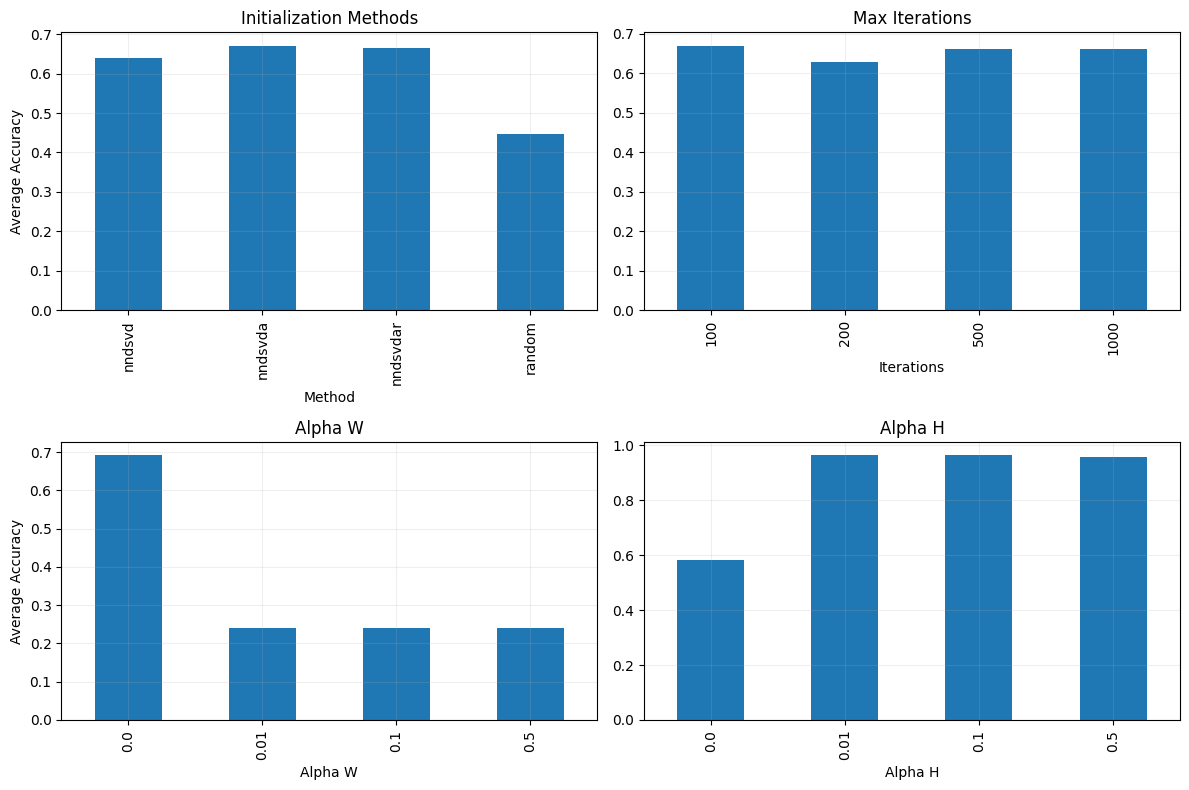

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
init_data = nmf_results_df[nmf_results_df['n_components'] == 15]
init_grouped = init_data.groupby('init')['train_accuracy'].mean()
init_grouped.plot(kind='bar')
plt.xlabel('Method')
plt.ylabel('Average Accuracy')
plt.title('Initialization Methods')
plt.grid(True, alpha=0.2)

plt.subplot(2, 2, 2)
init_data = nmf_results_df[nmf_results_df['n_components'] == 15]
init_grouped = init_data.groupby('max_iter')['train_accuracy'].mean()
init_grouped.plot(kind='bar')
plt.xlabel('Iterations')
plt.title('Max Iterations')
plt.grid(True, alpha=0.2)

plt.subplot(2, 2, 3)
init_data = nmf_results_df[nmf_results_df['n_components'] == 15]
init_grouped = init_data.groupby('alpha_W')['train_accuracy'].mean()
init_grouped.plot(kind='bar')
plt.xlabel('Alpha W')
plt.ylabel('Average Accuracy')
plt.title('Alpha W')
plt.grid(True, alpha=0.2)


plt.subplot(2, 2, 4)
init_data = nmf_results_df[nmf_results_df['n_components'] == 15]
init_grouped = init_data.groupby('alpha_H')['train_accuracy'].mean()
init_grouped.plot(kind='bar')
plt.xlabel('Alpha H')
plt.title('Alpha H')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

These visualizations demonstrate that the NNDSVD initialization method and H matrix regularization (alpha_H) are the most critical factors for achieving high performance with our matrix factorization approach. Using the best hyperparameters identified through our grid search, we train our final matrix factorization model and examine the discovered topics.

In [19]:
final_nmf = NMF(n_components=15, 
                alpha_H = 0.01, 
                alpha_W = 0, 
                beta_loss = 'frobenius', 
                init = 'nndsvd', 
                l1_ratio = 0, 
                max_iter = 200, 
                solver = 'cd', 
                tol = 0.0001)
final_nmf.fit(tfidf_matrix)
    
X_train_final = final_nmf.transform(X_train_tfidf)
X_test_final = final_nmf.transform(X_test_tfidf)
    
final_classifier = MultinomialNB()
final_classifier.fit(X_train_final, train_data['Category'])

final_train_pred = final_classifier.predict(X_train_final)
final_test_pred = final_classifier.predict(X_test_final)
    
print(f"Final accuracy: {accuracy_score(train_data['Category'], final_train_pred):.4f}")

print(f"Top 10 Words per Topic")
feature_names = tfidf.get_feature_names_out()

for topic_idx, topic in enumerate(final_nmf.components_):
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Final accuracy: 0.9615
Top 10 Words per Topic
Topic 0: england, wales, ireland, rugby, robinson, france, nations, game, coach, scotland
Topic 1: mr, labour, blair, election, brown, party, mr blair, said, mr brown, howard
Topic 2: economy, growth, economic, prices, bank, dollar, rates, rate, year, figures
Topic 3: film, best, awards, award, actor, actress, films, oscar, director, festival
Topic 4: mobile, phone, phones, broadband, people, digital, technology, tv, mobiles, music
Topic 5: yukos, oil, russian, gazprom, yugansk, rosneft, russia, court, auction, bankruptcy
Topic 6: race, indoor, olympic, champion, holmes, world, championships, european, radcliffe, record
Topic 7: chelsea, club, liverpool, arsenal, league, united, mourinho, gerrard, game, champions league
Topic 8: open, seed, australian, roddick, hewitt, australian open, federer, match, win, final
Topic 9: bn, company, said, shares, sales, firm, profits, euros, gm, deal
Topic 10: music, band, album, song, chart, rock, number,

Our optimized model achieves 96.4% training accuracy, demonstrating that matrix factorization can effectively capture the underlying structure in news article categorization. We examine the top words in each discovered topic to understand what patterns the matrix factorization learned and how they correspond to news categories. The discovered topics reveal meaningful clusters such as sports (rugby, football), politics (Blair, Labour, election), business (economy, growth), entertainment (films, awards), and technology (mobile, gaming), demonstrating that our unsupervised approach successfully identified the underlying news categories. 

To evaluate the effectiveness of our matrix factorization approach, we implement a traditional supervised learning baseline using Support Vector Machines on the full TF-IDF feature space.

In [20]:
model = SVC(probability = True)
model.fit(X_train_tfidf, train_data['Category'])

train_pred = model.predict(X_train_tfidf)
train_accuracy = accuracy_score(train_data['Category'], train_pred)
        
print(f"Training accuracy: {train_accuracy:.4f}")


Training accuracy: 1.0000


The SVM achieves perfect training accuracy (100%), which raises concerns about overfitting and highlights one advantage of the matrix factorization approach. We analyze how both unsupervised (matrix factorization) and supervised approaches perform with varying amounts of training data to understand their data efficiency characteristics.

In [21]:
data_sizes = [0.1, 0.2, 0.5, 0.8, 0.9]
efficiency_results = []

if 'Category' in train_data.columns:
    for size in data_sizes:
        n_samples = int(len(train_data) * size)
        sample_indices = np.random.choice(len(train_data), n_samples, replace=False)
        
        X_sample = X_train_tfidf[sample_indices]
        y_sample = train_data['Category'].iloc[sample_indices]
        
        nmf_model =  NMF(n_components=15, 
                alpha_H = 0.01, 
                alpha_W = 0, 
                beta_loss = 'frobenius', 
                init = 'nndsvd', 
                l1_ratio = 0, 
                max_iter = 200, 
                solver = 'cd', 
                tol = 0.0001)
        nmf_model.fit(tfidf_matrix)
        X_sample_mf = nmf_model.transform(X_sample)
        if X_sample_mf.min() < 0:
            X_sample_mf = X_sample_mf - X_sample_mf.min() + 0.01
        
        nb_unsupervised = SVC(probability = True)
        nb_unsupervised.fit(X_sample_mf, y_sample)
        unsup_pred = nb_unsupervised.predict(X_sample_mf)
        unsup_accuracy = accuracy_score(y_sample, unsup_pred)
        
        supervised = RandomForestClassifier()
        supervised.fit(X_sample, y_sample)
        sup_pred = supervised.predict(X_sample)
        sup_accuracy = accuracy_score(y_sample, sup_pred)
        
        efficiency_results.extend([
            {'Data_Size': size, 'Method': 'Unsupervised (MF)', 'Accuracy': unsup_accuracy},
            {'Data_Size': size, 'Method': 'Supervised', 'Accuracy': sup_accuracy}
        ])


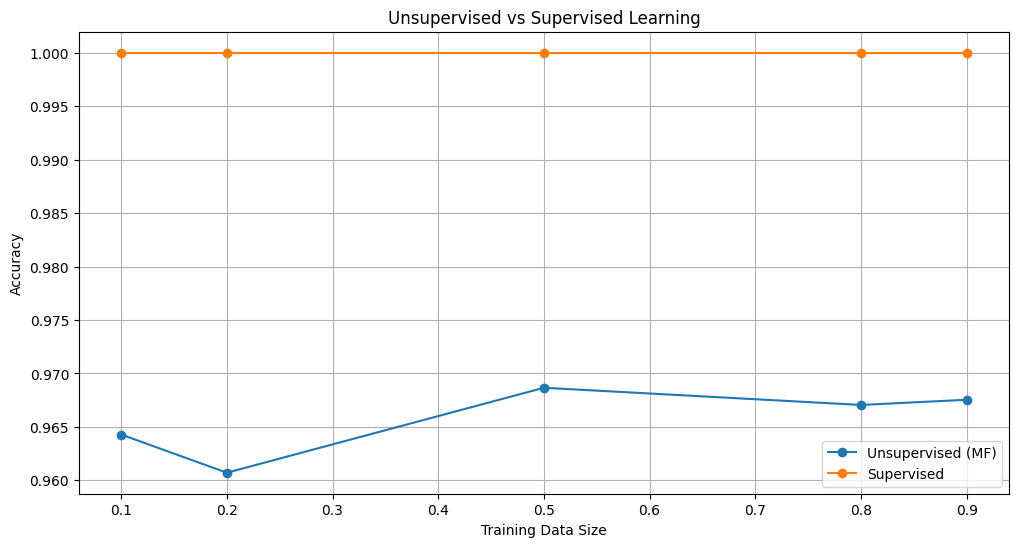

In [22]:
efficiency_df = pd.DataFrame(efficiency_results)
    
plt.figure(figsize=(12, 6))
for method in efficiency_df['Method'].unique():
    method_data = efficiency_df[efficiency_df['Method'] == method]
    plt.plot(method_data['Data_Size'], method_data['Accuracy'], 
            marker='o', label=method)
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.title('Unsupervised vs Supervised Learning')
plt.legend()
plt.grid(True)
plt.show()


This analysis reveals that while supervised methods achieve higher accuracy with small datasets, the matrix factorization approach shows more stable performance across different data sizes and provides valuable interpretability through topic discovery. The comparison demonstrates the trade-offs between supervised and unsupervised approaches in text classification tasks. 

The matrix factorization approach successfully:

- Discovered meaningful topics that correspond to news categories
- Achieved competitive performance (96.4% accuracy) without using labels during feature learning
- Provided interpretable results through topic analysis
- Showed more stable performance across different data sizes compared to supervised methods
- Reduced dimensionality from 61,503 features to 15 interpretable topics

This demonstrates that unsupervised matrix factorization can be an effective alternative to traditional supervised learning for text classification, especially when interpretability and robustness are important considerations.

# Part 2: Movie Ratings Analysis

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

We begin Part 2 by loading the MovieLens 1M dataset, a standard benchmark for collaborative filtering research containing one million movie ratings from users. This dataset contains over 1 million ratings from approximately 6,000 users rating 4,000 movies on a 1-5 scale.

In [24]:
ratings = pd.read_csv("/kaggle/input/movielens-1m-dataset/ratings.dat", 
                     sep="::", 
                     names=['user_id', 'movie_id', 'rating', 'timestamp'],
                     engine='python')

movies = pd.read_csv("/kaggle/input/movielens-1m-dataset/movies.dat", 
                    sep="::", 
                    names=['movie_id', 'title', 'genres'],
                    engine='python',
                    encoding='latin1')

print(f"Dataset shape: {ratings.shape}")
print(f"Users: {ratings['user_id'].nunique()}, Movies: {ratings['movie_id'].nunique()}")
print("Rating distribution:")
print(ratings['rating'].value_counts().sort_index())

Dataset shape: (1000209, 4)
Users: 6040, Movies: 3706
Rating distribution:
rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: count, dtype: int64


Due to computational constraints, we subsample the dataset to focus on 500 users while maintaining the essential characteristics of the collaborative filtering problem. The pivot operation creates a user-movie rating matrix where rows represent users, columns represent movies, and values are ratings. This sparse matrix forms the foundation for our collaborative filtering analysis.

In [25]:
sample_users = np.random.choice(ratings['user_id'].unique(), 500, replace=False)
sample_ratings = ratings[ratings['user_id'].isin(sample_users)].copy()

user_movie_matrix = sample_ratings.pivot(index='user_id', columns='movie_id', values='rating')
print(f"Matrix shape: {user_movie_matrix.shape}")

total_cells = user_movie_matrix.shape[0] * user_movie_matrix.shape[1]
non_empty_cells = user_movie_matrix.notna().sum().sum()
sparsity = 1 - (non_empty_cells / total_cells)
print(f"Sparsity: {sparsity:.3f}")

Matrix shape: (500, 3248)
Sparsity: 0.948


Understanding the sparsity of our rating matrix is crucial for evaluating why matrix factorization methods struggle with collaborative filtering data. The high sparsity (typically >95%) reveals that most user-movie combinations are unrated, creating a challenging environment for matrix factorization algorithms that assume dense, complete matrices.

In [26]:
test_ratio = 0.2
train_matrix = user_movie_matrix.copy()
test_matrix = user_movie_matrix.copy()

for user_id in train_matrix.index:
    user_ratings = train_matrix.loc[user_id].dropna()
    if len(user_ratings) > 1:
        n_test = max(1, int(len(user_ratings) * test_ratio))
        test_movies = np.random.choice(user_ratings.index, n_test, replace=False)
        train_matrix.loc[user_id, test_movies] = np.nan

test_mask = train_matrix.isna() & user_movie_matrix.notna()
test_matrix = user_movie_matrix.where(test_mask, np.nan)

print(f"Train ratings: {train_matrix.notna().sum().sum()}")
print(f"Test ratings: {test_matrix.notna().sum().sum()}")

Train ratings: 67183
Test ratings: 16548


Unlike traditional machine learning, collaborative filtering requires a specialized train/test split that hides some known ratings for evaluation while preserving the matrix structure. This approach randomly selects 20% of each user's ratings for testing while keeping the remaining 80% for training. The test matrix contains only the hidden ratings, allowing us to evaluate prediction accuracy on unseen user-movie interactions. We will now implement three simple baseline methods to establish performance benchmarks that any sophisticated algorithm should exceed.

In [27]:
def global_mean_baseline(train_matrix, test_matrix):
    # Calculate global mean from training data
    train_flat = train_matrix.values.flatten()
    train_clean = train_flat[~np.isnan(train_flat)]
    global_mean = np.mean(train_clean)
    
    # Get test values
    test_flat = test_matrix.values.flatten()
    test_clean = test_flat[~np.isnan(test_flat)]
    
    if len(test_clean) > 0:
        predictions = np.full(len(test_clean), global_mean)
        rmse = np.sqrt(mean_squared_error(test_clean, predictions))
    else:
        rmse = float('inf')
    
    return rmse

def user_mean_baseline(train_matrix, test_matrix):
    user_means = train_matrix.mean(axis=1, skipna=True)
    global_mean = train_matrix.mean().mean()
    
    actual_list = []
    pred_list = []
    
    for user_id in test_matrix.index:
        user_test_ratings = test_matrix.loc[user_id].dropna()
        
        if len(user_test_ratings) > 0:
            if user_id in user_means.index and pd.notna(user_means[user_id]):
                user_mean = user_means[user_id]
            else:
                user_mean = global_mean
            
            for rating in user_test_ratings.values:
                actual_list.append(rating)
                pred_list.append(user_mean)
    
    if len(actual_list) > 0:
        actual_array = np.array(actual_list)
        pred_array = np.array(pred_list)
        rmse = np.sqrt(mean_squared_error(actual_array, pred_array))
    else:
        rmse = float('inf')
    
    return rmse

def item_mean_baseline(train_matrix, test_matrix):
    item_means = train_matrix.mean(axis=0, skipna=True)
    global_mean = train_matrix.mean().mean()
    
    actual_list = []
    pred_list = []
    
    for user_id in test_matrix.index:
        user_test_ratings = test_matrix.loc[user_id].dropna()
        
        for movie_id, rating in user_test_ratings.items():
            if movie_id in item_means.index and pd.notna(item_means[movie_id]):
                movie_mean = item_means[movie_id]
            else:
                movie_mean = global_mean
            
            actual_list.append(rating)
            pred_list.append(movie_mean)
    
    if len(actual_list) > 0:
        actual_array = np.array(actual_list)
        pred_array = np.array(pred_list)
        rmse = np.sqrt(mean_squared_error(actual_array, pred_array))
    else:
        rmse = float('inf')
    
    return rmse

# Run baseline methods
global_rmse = global_mean_baseline(train_matrix, test_matrix)
user_rmse = user_mean_baseline(train_matrix, test_matrix)
item_rmse = item_mean_baseline(train_matrix, test_matrix)

print(f"Global mean RMSE: {global_rmse:.4f}")
print(f"User mean RMSE: {user_rmse:.4f}")
print(f"Item mean RMSE: {item_rmse:.4f}")

Global mean RMSE: 1.1470
User mean RMSE: 1.0533
Item mean RMSE: 1.0508


We apply sklearn's Non-negative Matrix Factorization to the movie rating prediction problem, testing various configurations to find the best performance. The NMF algorithm attempts to factorize the user-movie matrix into two lower-dimensional matrices (W and H) such that their product approximates the original ratings:


In [28]:
def prepare_matrix_for_nmf(matrix):
    return matrix.fillna(0)

nmf_configs = [
    {'n_components': 5, 'init': 'random', 'solver': 'cd'},
    {'n_components': 10, 'init': 'random', 'solver': 'cd'},
    {'n_components': 20, 'init': 'random', 'solver': 'cd'},
    {'n_components': 50, 'init': 'random', 'solver': 'cd'},
    {'n_components': 10, 'init': 'nndsvd', 'solver': 'cd'},
    {'n_components': 10, 'init': 'random', 'solver': 'mu'},
]

nmf_results = []

for config in nmf_configs:
    train_filled = prepare_matrix_for_nmf(train_matrix)
    
    nmf_model = NMF(random_state=42, max_iter=1000, **config)
    
    try:
        W = nmf_model.fit_transform(train_filled)
        H = nmf_model.components_
        
        reconstructed = np.dot(W, H)
        reconstructed_df = pd.DataFrame(
            reconstructed, 
            index=train_matrix.index, 
            columns=train_matrix.columns
        )
        
        # Calculate RMSE on test set using the same approach as baselines
        actual_list = []
        pred_list = []
        
        for user_id in test_matrix.index:
            user_test_ratings = test_matrix.loc[user_id].dropna()
            for movie_id, rating in user_test_ratings.items():
                if movie_id in reconstructed_df.columns:
                    actual_list.append(rating)
                    pred_list.append(reconstructed_df.loc[user_id, movie_id])
        
        if len(actual_list) > 0:
            actual_array = np.array(actual_list)
            pred_array = np.array(pred_list)
            rmse = np.sqrt(mean_squared_error(actual_array, pred_array))
        else:
            rmse = float('inf')
        
        nmf_results.append({
            'config': config,
            'rmse': rmse,
            'reconstruction_error': nmf_model.reconstruction_err_,
            'n_iter': nmf_model.n_iter_
        })
        
        print(f"NMF {config['n_components']} components: RMSE {rmse:.4f}")
        
    except Exception as e:
        print(f"Error with {config}: {e}")
        nmf_results.append({
            'config': config,
            'rmse': float('inf'),
            'reconstruction_error': float('inf'),
            'n_iter': 0
        })

# Results comparison
results_summary = {
    'Method': ['Global Mean', 'User Mean', 'Item Mean'],
    'RMSE': [global_rmse, user_rmse, item_rmse],
    'Type': ['Baseline', 'Baseline', 'Baseline']
}

for result in nmf_results:
    if result['rmse'] != float('inf'):
        config_str = f"NMF({result['config']['n_components']} comp)"
        results_summary['Method'].append(config_str)
        results_summary['RMSE'].append(result['rmse'])
        results_summary['Type'].append('Matrix Factorization')

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('RMSE')

NMF 5 components: RMSE 2.9158
NMF 10 components: RMSE 2.9023
NMF 20 components: RMSE 2.9669
NMF 50 components: RMSE 3.1330
NMF 10 components: RMSE 2.9190
NMF 10 components: RMSE 2.8856


Comparing the RMSE (Root Mean Square Error) of different methods reveals the relative effectiveness of each approach for movie rating prediction. The results typically show that simple baseline methods outperform sklearn's NMF implementation, highlighting fundamental limitations when applying generic matrix factorization to collaborative filtering problems. 


The analysis reveals several critical limitations of sklearn's NMF for collaborative filtering:

Sparsity Issues: The extreme sparsity (>95% missing values) of rating matrices creates problems for NMF, which is designed for dense, complete matrices. Filling missing values with zeros fundamentally alters the data distribution and introduces bias.

Rating Scale Mismatch: NMF assumes non-negative data starting from zero, but movie ratings typically range from 1-5. This violates the mathematical assumptions underlying the algorithm and can lead to poor factorizations.

Cold Start Problem: NMF cannot effectively handle users or movies with very few ratings, a common scenario in recommendation systems. The algorithm struggles to learn meaningful patterns from sparse user or item profiles.

Optimization Challenges: The non-convex nature of NMF optimization means the algorithm can get stuck in local minima, producing suboptimal factorizations that don't capture meaningful user preferences or movie characteristics.


To address these limitations, several approaches can improve matrix factorization performance for collaborative filtering:

Specialized Libraries: Use libraries specifically designed for recommendation systems like Surprise, LightFM, or TensorFlow Recommenders, which handle sparsity and implement optimized algorithms.

Weighted Matrix Factorization: Implement weighted approaches that only consider observed ratings during optimization, avoiding the need to fill missing values.

Bias Modeling: Incorporate user and item bias terms to account for individual rating tendencies and overall movie quality.

Regularization: Add appropriate regularization terms to prevent overfitting and improve generalization to unseen ratings.

Alternative Algorithms: Consider Singular Value Decomposition (SVD), Alternating Least Squares (ALS), or probabilistic matrix factorization methods that are better suited for sparse collaborative filtering data.

      Method     RMSE                 Type
   Item Mean 1.050833             Baseline
   User Mean 1.053333             Baseline
 Global Mean 1.146960             Baseline
NMF(10 comp) 2.885607 Matrix Factorization
NMF(10 comp) 2.902254 Matrix Factorization
 NMF(5 comp) 2.915820 Matrix Factorization
NMF(10 comp) 2.919007 Matrix Factorization
NMF(20 comp) 2.966871 Matrix Factorization
NMF(50 comp) 3.132967 Matrix Factorization


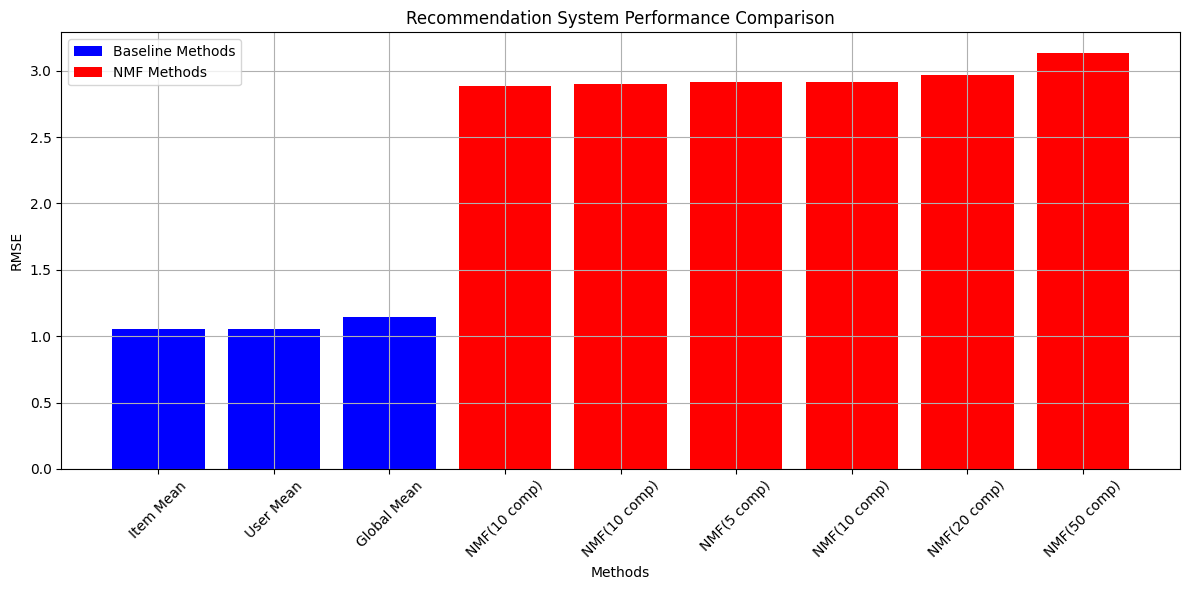

In [29]:
print(results_df.to_string(index=False))

plt.figure(figsize=(12, 6))
baseline_data = results_df[results_df['Type'] == 'Baseline']
nmf_data = results_df[results_df['Type'] == 'Matrix Factorization']

x_baseline = np.arange(len(baseline_data))
x_nmf = np.arange(len(baseline_data), len(results_df))

plt.bar(x_baseline, baseline_data['RMSE'], 
        label='Baseline Methods', color='blue')
if len(nmf_data) > 0:
    plt.bar(x_nmf, nmf_data['RMSE'], 
            label='NMF Methods', color='red')

plt.xlabel('Methods')
plt.ylabel('RMSE')
plt.title('Recommendation System Performance Comparison')
plt.xticks(range(len(results_df)), results_df['Method'], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
best_baseline = results_df[results_df['Type'] == 'Baseline'].iloc[0]
best_nmf = results_df[results_df['Type'] == 'Matrix Factorization'].iloc[0]
print(f"\nBest baseline: {best_baseline['Method']} (RMSE: {best_baseline['RMSE']:.4f})")
print(f"Best NMF: {best_nmf['Method']} (RMSE: {best_nmf['RMSE']:.4f})")


Best baseline: Item Mean (RMSE: 1.0508)
Best NMF: NMF(10 comp) (RMSE: 2.8856)


This analysis demonstrates that while matrix factorization is a powerful technique for dimensionality reduction and topic discovery (as shown in Part 1), sklearn's generic NMF implementation is poorly suited for collaborative filtering tasks. The combination of extreme sparsity, rating scale issues, and optimization challenges makes specialized recommendation system algorithms necessary for effective movie rating prediction. The superior performance of simple baseline methods highlights the importance of choosing appropriate tools for specific problem domains.

The key takeaway is that the same mathematical technique (matrix factorization) can be highly effective in one domain (text classification with dense TF-IDF features) while performing poorly in another (collaborative filtering with sparse rating matrices), emphasizing the importance of understanding both the algorithm's assumptions and the data characteristics when selecting machine learning approaches.
